In [1]:
# CREDIT TO PATRICK LOEBER'S YOUTUBE TUTORIAL FOR MOST OF THE BELOW CODE
# I replaced his use of nltk Vader's SIA with a transformer
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# Import the reddit API package and initialize our reddit client
import praw

user_agent = "Sentiment Analyzer 1.0 by /u/E4_Koga"
reddit = praw.Reddit(
    client_id="t1JxBc-CvFjzujHmQV95GQ",
    client_secret="Xqex1Bx8naXsfmLJn5mXLaOhJx_h3Q",
    user_agent=user_agent
)

In [18]:
# First step, gather the headlines from the subreddit
headlines = set()
SUBREDDIT_NAME = 'stocks'
for submission in reddit.subreddit(SUBREDDIT_NAME).hot(limit=None):
    # print(submission.title)
    # print(submission.id)
    # print(submission.author)
    # print(submission.created_utc) # convert utc to readable PT datetime 
    # print(submission.score)
    # print(submission.upvote_ratio)
    # print(submission.url)
    headlines.add(submission.title)
print(len(headlines))

434


In [9]:
# Let's visualize the headlines using pandas
df = pd.DataFrame(headlines)
df.head()

,0
0,Elon Musk POS but thank you!
1,best play for a recession? spy puts?
2,ASTS not gonna launch tho
3,The Cofounder of Oracle just bought Paramount
4,ORCLE Earnings


In [10]:
# Convert the dataframe to a format we can feed the NLTK tool
df.to_csv('headlines.csv', header=False, encoding='utf-8', index=False)

In [40]:
from transformers import pipeline
from pprint import pprint
import pandas as pd

# Initialize the Hugging Face sentiment analysis pipeline with GPU support
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment", device=0)

# Define a mapping from model labels to sentiment names
label_to_sentiment = {
    'LABEL_0': 'negative',
    'LABEL_1': 'neutral',
    'LABEL_2': 'positive'
}

results = []

# Iterate over each headline and get sentiment prediction
for line in headlines:
    sentiment = sentiment_pipeline(line)  # Perform sentiment analysis
    pol_score = sentiment[0]  # Extract the first result (sentiment analysis pipeline returns a list)
    
    # Map the label to its corresponding sentiment name
    pol_score['headline'] = line  # Add the original headline to the results
    pol_score['sentiment'] = label_to_sentiment[pol_score['label']]  # Map and store the sentiment class
    results.append(pol_score)

# Display the results
pprint(results[:3], width=100)

# Convert results to DataFrame for further analysis
df = pd.DataFrame.from_records(results)
df.drop(columns=['label'], inplace=True)
df.head()


/Users/rn/Code/reddit_sentiment_analysis/.venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


[{'headline': 'Elon Musk POS but thank you!',
  'label': 'LABEL_2',
  'score': 0.5521805286407471,
  'sentiment': 'positive'},
 {'headline': 'best play for a recession? spy puts?',
  'label': 'LABEL_1',
  'score': 0.6440161466598511,
  'sentiment': 'neutral'},
 {'headline': 'ASTS not gonna launch tho',
  'label': 'LABEL_1',
  'score': 0.6327182054519653,
  'sentiment': 'neutral'}]


,score,headline,sentiment
0,0.552181,Elon Musk POS but thank you!,positive
1,0.644016,best play for a recession? spy puts?,neutral
2,0.632718,ASTS not gonna launch tho,neutral
3,0.781731,The Cofounder of Oracle just bought Paramount,neutral
4,0.841552,ORCLE Earnings,neutral


In [54]:
# Set a confidence score threshold to filter confidence score against
confidence_threshold = 0.75

# Filter the DataFrame based on the threshold and drop it
filtered_df = df[df['score'] >= confidence_threshold]
filtered_df.drop(columns=['score'], inplace=True)

# Display the filtered DataFrame
filtered_df.to_csv(f'{SUBREDDIT_NAME}_headlines_labels.csv', encoding='utf-8', index=False)
filtered_df.head()

/var/folders/hb/rp285xgs42z09t5zr56tgny80000gn/T/ipykernel_28109/3400100366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.drop(columns=['score'], inplace=True)


,headline,sentiment
3,The Cofounder of Oracle just bought Paramount,neutral
4,ORCLE Earnings,neutral
8,"NIO Q2 Earnings: EPS Beat, Deliveries Growth, ...",positive
9,Boeing Puts,neutral
10,"Nvidia reports 122% revenue growth, $50 billio...",positive


In [56]:
# Now that we have our data and SIA output, we can use the above libraries for some data analysis

counts = (filtered_df.sentiment.value_counts(normalize=True) * 100)

pprint("Value counts of sentiment classes")
pprint(counts)

print("\nPositive headlines:\n")
pprint(list(df[df['sentiment'] == 'positive'].headline)[:5], width=200)

print("\nNeutral headlines:\n")
pprint(list(df[df['sentiment'] == 'neutral'].headline)[:5], width=200)

print("\nNegative headlines:\n")
pprint(list(df[df['sentiment'] == 'negative'].headline)[:5], width=200)

'Value counts of sentiment classes'
sentiment
neutral     78.18930
positive    13.99177
negative     7.81893
Name: proportion, dtype: float64

Positive headlines:

['Elon Musk POS but thank you!',
 'NIO Q2 Earnings: EPS Beat, Deliveries Growth, Strong Q3, Outlook And More',
 'Nvidia reports 122% revenue growth, $50 billion in share buybacks!',
 'Managed to 2.9x money. Turning 8.7K to 25.8K (17.1K profit). NVDA Lucky Put👍.',
 'NVDA Puts closed for 85% Gain ($3,000+). I will reload later. Happy September boys. Should be a fun one. ']

Neutral headlines:

['best play for a recession? spy puts?', 'ASTS not gonna launch tho', 'The Cofounder of Oracle just bought Paramount', 'ORCLE Earnings', 'I don’t even trade options…']

Negative headlines:

['Here is why LUNR spiked today ',
 'SPX said no Wendy’s for you today ',
 '60%+ that the market would crater from job reports',
 'NVDA is a money destroying machine lately',
 'Why is ATT not falling with the rest of the market? ']


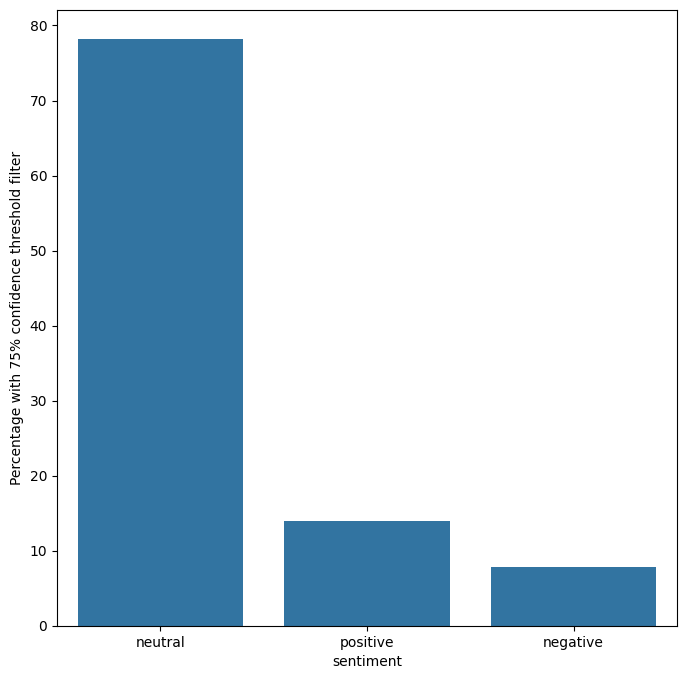

In [58]:
# The powerful matplotlib library allows for more advanced data visualization

fig, ax = plt.subplots(figsize=(8,8))

sns.barplot(x=counts.index, y=counts, ax=ax)

# ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage with 75% confidence threshold filter")

plt.show()